# Libraries

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import webbrowser
import pandas as pd
import importlib
import subprocess
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
import h2o
from h2o.estimators import H2ORandomForestEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

h2o:1: DeprecationWarning: Your Python version is 3.10.10. The support for this version will be removed in H2O 3.42.0.1.


# Functions

In [10]:
def pandas_to_h2o(data):
    # Convert Pandas DataFrame to H2OFrame
    h2o_df = h2o.H2OFrame(data)
    return h2o_df

def h2o_to_pandas(h2o_df):
    # Convert H2OFrame to Pandas DataFrame
    pandas_df = h2o_df.as_data_frame()

    return pandas_df

In [12]:
def install_h2o_package():
    try:
        importlib.import_module('h2o')
        print('H2O package is already installed')
    except ImportError:
        print('H2O package not found, installing with pip...')
        subprocess.call(['pip', 'install', 'h2o'])

In [3]:
def identify_binary_continuous_columns(data: pd.DataFrame, target_column: str) -> tuple:
    """
    Identify binary and continuous columns in a Pandas DataFrame.

    Parameters:
    data (pandas.DataFrame): The input Pandas DataFrame.
    target_column (str): The name of the target column.

    Returns:
    tuple: A tuple of two lists containing the binary and continuous columns, respectively.

    """
    binary_columns = []
    continuous_columns = []

    for column in data.columns:
        if column != target_column:
            unique_values = len(data[column].unique())
            if unique_values == 2:
                binary_columns.append(column)
            elif unique_values > 2:
                continuous_columns.append(column)

    return binary_columns, continuous_columns


In [4]:
def convert_binary_to_categorical(data, binary_columns):
    """
    Convert binary columns in a DataFrame to categorical data type.

    :param data: A pandas DataFrame containing the data.
    :param binary_columns: A list of column names that are binary.
    :return: A new pandas DataFrame with binary columns converted to categorical data type.
    """
    data_categorical = data.copy()

    for column in binary_columns:
        data_categorical[column] = data_categorical[column].astype('category')

    return data_categorical

In [5]:
def convert_to_h2o_frame(X_train, y_train, X_test, y_test, target_column):
    """
    Convert pandas DataFrames X_train, y_train, X_test, and y_test to H2OFrames.
    
    :param X_train: A pandas DataFrame containing the training feature data.
    :param y_train: A pandas DataFrame containing the training target data.
    :param X_test: A pandas DataFrame containing the test feature data.
    :param y_test: A pandas DataFrame containing the test target data.
    :param target_column: The name of the target column in the data.
    :return: Four H2OFrames: train, test, X_train_h2o, X_test_h2o.
    """
    train_df = X_train.copy()
    train_df[target_column] = y_train

    test_df = X_test.copy()
    test_df[target_column] = y_test

    train_h2o = h2o.H2OFrame(train_df)
    test_h2o = h2o.H2OFrame(test_df)

    X_train_h2o = h2o.H2OFrame(X_train)
    X_test_h2o = h2o.H2OFrame(X_test)

    return train_h2o, test_h2o, X_train_h2o, X_test_h2o

In [6]:
def binary_classification_metrics(y_true, y_pred):
    """
    Calculate and print binary classification metrics: accuracy, confusion matrix, and classification report.
    
    :param y_true: A pandas DataFrame or Series containing the true target values.
    :param y_pred: A pandas DataFrame or Series containing the predicted target values.
    :return: A dictionary containing the calculated classification metrics.
    """
    # Calculate classification metrics
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    metrics['classification_report'] = classification_report(y_true, y_pred)
    
    # Print the classification metrics
    print('Accuracy:', metrics['accuracy'])
    print('Confusion Matrix:\n', metrics['confusion_matrix'])
    print('Classification Report:\n', metrics['classification_report'])

    return metrics


In [7]:
def evaluate_predictions(y_true,
                         y_pred,
                         positive_class=1,
                         roc_file='roc_plot.html',
                         pr_file='pr_plot.html'):
    """
    Evaluate classification metrics, plot ROC curve and Precision-Recall curve using Plotly, and save plots as HTML files.

    :param y_true: A pandas DataFrame or Series containing the true target values.
    :param y_pred: A pandas DataFrame or Series containing the predicted target values.
    :param positive_class: The label of the positive class (default: 1).
    :param roc_file: The name of the HTML file to save the ROC curve plot (default: 'roc_plot.html').
    :param pr_file: The name of the HTML file to save the Precision-Recall curve plot (default: 'pr_plot.html').
    :return: A dictionary containing various classification metrics.
    """
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=positive_class)
    metrics['auc'] = auc(fpr, tpr)

    # Calculate Precision-Recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_true,
                                                  y_pred,
                                                  pos_label=positive_class)
    metrics['average_precision'] = average_precision_score(y_true, y_pred)

    # Create ROC curve plot
    fig_roc = make_subplots(rows=1, cols=1, subplot_titles=('ROC Curve', ))
    fig_roc.add_trace(go.Scatter(x=fpr,
                                 y=tpr,
                                 mode='lines',
                                 name='ROC Curve',
                                 line=dict(color='blue')),
                      row=1,
                      col=1)
    fig_roc.add_trace(go.Scatter(x=[0, 1],
                                 y=[0, 1],
                                 mode='lines',
                                 name='Random',
                                 line=dict(color='black', dash='dash')),
                      row=1,
                      col=1)
    fig_roc.update_layout(title=f'ROC Curve (AUC = {metrics["auc"]:.4f})',
                          xaxis_title='False Positive Rate',
                          yaxis_title='True Positive Rate',
                          showlegend=True,
                          legend=dict(orientation='h',
                                      yanchor='bottom',
                                      xanchor='right',
                                      y=1.02,
                                      x=1))

    # Save the ROC curve plot as an HTML file
    pio.write_html(fig_roc, file=roc_file)

    # Create Precision-Recall curve plot
    fig_pr = make_subplots(rows=1,
                           cols=1,
                           subplot_titles=('Precision-Recall Curve', ))
    fig_pr.add_trace(go.Scatter(x=recall,
                                y=precision,
                                mode='lines',
                                name='Precision-Recall Curve',
                                line=dict(color='blue')),
                     row=1,
                     col=1)
    fig_pr.update_layout(
        title=
        f'Precision-Recall Curve (Avg. Precision = {metrics["average_precision"]:.4f})',
        xaxis_title='Recall',
        yaxis_title='Precision',
        showlegend=True,
        legend=dict(orientation='h',
                    yanchor='bottom',
                    xanchor='right',
                    y=1.02,
                    x=1))

    # Save the Precision-Recall curve plot as an HTML file
    pio.write_html(fig_pr, file=pr_file)

    # Print classification metrics nicely

    print(f'AUC: {metrics["auc"]:.4f}')
    print(f'Average Precision: {metrics["average_precision"]:.4f}')

    # Open the HTML files in the default web browser
    webbrowser.open(roc_file)
    webbrowser.open(pr_file)

    return metrics

In [20]:
def exclude_columns(data: pd.DataFrame, exclude_list: list) -> pd.DataFrame:
    """
    Exclude specified columns from a Pandas DataFrame.

    Parameters:
    data (pandas.DataFrame): The input Pandas DataFrame.
    exclude_list (list): The list of column names to exclude.

    Returns:
    pandas.DataFrame: A new DataFrame with the specified columns removed.

    """
    new_data = data.drop(exclude_list, axis=1)

    return new_data

# Parameters

In [22]:
# Define the list of columns to exclude
exclude_list = ['pagerank', 'betweeneness', 'centrality_degree', 'eigenvector', 'katz', 'closeness']

# Auto ML

## Install the H2O package:

In [13]:
# Check if H2O package is installed, and if not, install it
install_h2o_package()

H2O package is already installed


## Init H20

In [14]:
#Import the necessary libraries and start the H2O cluster:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_371"; Java(TM) SE Runtime Environment (build 1.8.0_371-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.371-b11, mixed mode)
  Starting server from /Users/yil1/opt/anaconda3/envs/P2P/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/p7/yz9l_v5n4cx5x7hgbnl67by40000gn/T/tmpyfcmott9
  JVM stdout: /var/folders/p7/yz9l_v5n4cx5x7hgbnl67by40000gn/T/tmpyfcmott9/h2o_yil1_started_from_python.out
  JVM stderr: /var/folders/p7/yz9l_v5n4cx5x7hgbnl67by40000gn/T/tmpyfcmott9/h2o_yil1_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Zurich
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_yil1_n1qyw5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.094 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


## Read the data

In [16]:
# Load your dataset:
file_name = "/Users/yil1/Documents/GitHub/P2P-Model-Bondora/data/sample_10k.txt"
data_all_features = h2o.import_file(file_name)
# data comes back as a h2o.frame.H2OFrame
# type(data_all_features)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
# convert to pandas dataframe
data_all_features = h2o_to_pandas(data_all_features)
#We wash data in the pandas dataframe, then convert it back to the h2o frame

In [18]:
data_all_features.head()

,default,new,Age,Gender,Interest,MonthlyPayment,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,time2,...,previous.repay.l,A,B,C,pagerank,betweeneness,centrality_degree,eigenvector,katz,closeness
0,0,1,51,0,19.33,5.284117,0,0.0,2.670,7.128900,...,0.000000,0,0,1,0.000139,0.0008,0.0003,1.374749e-03,0.010150,0.837797
1,0,1,28,0,16.23,5.241324,0,0.0,4.373,19.123129,...,0.000000,0,1,0,0.000045,0.0000,0.0001,1.840065e-19,0.009935,1.064964
2,0,0,40,0,13.34,4.438525,4,12200.0,2.938,8.631844,...,0.000000,0,1,0,0.000076,0.0000,0.0001,2.278947e-14,0.009981,0.848383
3,0,0,25,0,23.32,3.161247,2,1100.0,2.505,6.275025,...,6.398595,0,0,1,0.000116,0.0004,0.0002,2.048505e-06,0.010108,0.640333
4,0,1,50,0,18.45,4.771532,0,0.0,4.034,16.273156,...,0.000000,0,1,0,0.000056,0.0000,0.0001,1.917066e-15,0.009945,1.008507


In [19]:
data_all_features.columns

Index(['default', 'new', 'Age', 'Gender', 'Interest', 'MonthlyPayment',
       'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan',
       'time', 'time2',
       ...
       'previous.repay.l', 'A', 'B', 'C', 'pagerank', 'betweeneness',
       'centrality_degree', 'eigenvector', 'katz', 'closeness'],
      dtype='object', length=162)

## Preprocess the data
use min max scaler.
all binary columns to categorical

### Optionally exclude columns

In [23]:
# Exclude the specified columns
data = exclude_columns(data_all_features, exclude_list)

In [24]:
data.head()

,default,new,Age,Gender,Interest,MonthlyPayment,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,time2,...,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,previous.loan.l,no.previous.repay.00,no.previous.repay.01,previous.repay.l,A,B,C
0,0,1,51,0,19.33,5.284117,0,0.0,2.670,7.128900,...,0,0,0,0.000000,1,0,0.000000,0,0,1
1,0,1,28,0,16.23,5.241324,0,0.0,4.373,19.123129,...,0,0,0,0.000000,1,0,0.000000,0,1,0
2,0,0,40,0,13.34,4.438525,4,12200.0,2.938,8.631844,...,0,0,0,9.409273,1,0,0.000000,0,1,0
3,0,0,25,0,23.32,3.161247,2,1100.0,2.505,6.275025,...,0,0,0,7.003974,0,1,6.398595,0,0,1
4,0,1,50,0,18.45,4.771532,0,0.0,4.034,16.273156,...,0,0,0,0.000000,1,0,0.000000,0,1,0


### Identify binary Columns

In [25]:
# Identify the binary and continuous columns
binary_columns, continuous_columns = identify_binary_continuous_columns(data, 'target')

In [31]:
data[binary_columns].head(8)

,default,new,Gender,Hour.0,Hour.1,Hour.2,Hour.3,Hour.4,Hour.5,Hour.6,...,no.previous.loan.03,no.previous.loan.04,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,no.previous.repay.00,no.previous.repay.01,A,B,C
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
6,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [32]:
data[continuous_columns].head(8)

,Age,Interest,MonthlyPayment,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,time2,time3,log.amount,inc.princ.empl.l,...,inc.fam.all.l,inc.soc.wel.l,inc.leave.l,inc.child.l,inc.other.l,inc.total,liab.l,inc.support,previous.loan.l,previous.repay.l
0,51,19.33,5.284117,0,0.0,2.670,7.128900,19.034163,8.221479,6.566672,...,0.000000,0.0,0.0,0.0,0.000000,6.566672,6.152733,0.00000,0.000000,0.000000
1,28,16.23,5.241324,0,0.0,4.373,19.123129,83.625443,8.840870,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,6.846943,0.000000,0.00000,0.000000,0.000000
2,40,13.34,4.438525,4,12200.0,2.938,8.631844,25.360358,8.066208,6.692084,...,3.931826,0.0,0.0,0.0,0.000000,6.752270,6.306841,0.05848,9.409273,0.000000
3,25,23.32,3.161247,2,1100.0,2.505,6.275025,15.718938,6.606650,6.803505,...,0.000000,0.0,0.0,0.0,4.454347,6.893656,5.852346,0.00000,7.003974,6.398595
4,50,18.45,4.771532,0,0.0,4.034,16.273156,65.645911,6.862758,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,7.824446,0.000000,0.00000,0.000000,0.000000
5,42,17.37,2.899221,6,5275.0,3.102,9.622404,29.848697,6.272877,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,6.354370,4.577491,0.00000,8.570924,0.000000
6,39,10.17,5.250387,3,4455.0,3.033,9.199089,27.900837,8.578288,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,7.867489,6.975881,0.00000,8.402007,0.000000
7,29,15.44,2.724580,5,4135.0,4.397,19.333609,85.009879,6.274762,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,6.908755,0.000000,0.00000,8.327484,0.000000


### Convert binary to categorical

In [33]:
# Use the convert_binary_to_categorical function
data_categorical = convert_binary_to_categorical(data, binary_columns)

In [34]:
data_categorical

,default,new,Age,Gender,Interest,MonthlyPayment,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,time2,...,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,previous.loan.l,no.previous.repay.00,no.previous.repay.01,previous.repay.l,A,B,C
0,0,1,51,0,19.33,5.284117,0,0.0,2.670,7.128900,...,0,0,0,0.000000,1,0,0.000000,0,0,1
1,0,1,28,0,16.23,5.241324,0,0.0,4.373,19.123129,...,0,0,0,0.000000,1,0,0.000000,0,1,0
2,0,0,40,0,13.34,4.438525,4,12200.0,2.938,8.631844,...,0,0,0,9.409273,1,0,0.000000,0,1,0
3,0,0,25,0,23.32,3.161247,2,1100.0,2.505,6.275025,...,0,0,0,7.003974,0,1,6.398595,0,0,1
4,0,1,50,0,18.45,4.771532,0,0.0,4.034,16.273156,...,0,0,0,0.000000,1,0,0.000000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,39,1,15.45,3.510948,3,2085.0,2.881,8.300161,...,0,0,0,7.643004,0,1,6.398595,0,1,0
9996,1,0,25,0,13.34,2.702703,4,5305.0,3.104,9.634816,...,0,0,0,8.576594,1,0,0.000000,0,1,0
9997,1,1,61,1,20.96,4.478473,0,0.0,2.914,8.491396,...,0,0,0,0.000000,1,0,0.000000,0,0,1
9998,1,1,36,1,11.20,4.387760,0,0.0,3.954,15.634116,...,0,0,0,0.000000,1,0,0.000000,1,0,0


### Scale features

In [35]:
scaler = MinMaxScaler()
# Fit the scaler to the continuous features in the entire dataset
data_categorical[continuous_columns] = scaler.fit_transform(data_categorical[continuous_columns])

### Prepare all the washed data set

In [41]:
data_without_6_Features=data_categorical.copy()

## Set the target and feature columns

In [40]:
# Set the target and feature columns:
target_column = "default"
feature_columns = [col for col in data.columns if col != target_column]
feature_columns

['new',
 'Age',
 'Gender',
 'Interest',
 'MonthlyPayment',
 'NoOfPreviousLoansBeforeLoan',
 'AmountOfPreviousLoansBeforeLoan',
 'time',
 'time2',
 'time3',
 'Hour.0',
 'Hour.1',
 'Hour.2',
 'Hour.3',
 'Hour.4',
 'Hour.5',
 'Hour.6',
 'Hour.7',
 'Hour.8',
 'Hour.9',
 'Hour.10',
 'Hour.11',
 'Hour.12',
 'Hour.13',
 'Hour.14',
 'Hour.15',
 'Hour.16',
 'Hour.17',
 'Hour.18',
 'Hour.19',
 'Hour.20',
 'Hour.21',
 'Hour.22',
 'weekday.1',
 'weekday.2',
 'weekday.3',
 'weekday.4',
 'weekday.5',
 'weekday.6',
 'ver.3',
 'ver.4',
 'log.amount',
 'duration.06',
 'duration.09',
 'duration.12',
 'duration.18',
 'duration.24',
 'duration.36',
 'duration.48',
 'duration.60',
 'use.0',
 'use.1',
 'use.2',
 'use.3',
 'use.4',
 'use.5',
 'use.6',
 'use.7',
 'use.8',
 'educ.2',
 'educ.3',
 'educ.4',
 'educ.5',
 'marital.1',
 'marital.2',
 'marital.3',
 'marital.4',
 'marital.5',
 'depen.0',
 'depen.1',
 'depen.2',
 'depen.3',
 'depen.4',
 'employ.2',
 'employ.3',
 'employ.4',
 'employ.5',
 'employ.6',
 '

## Train test split

In [42]:
X = data_without_6_Features.drop(target_column, axis=1)
y = data_without_6_Features[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Convert to H20

In [43]:
train_h2o, test_h2o, X_train_h2o, X_test_h2o = convert_to_h2o_frame(
    X_train, y_train, X_test, y_test, target_column)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [45]:
train_h2o.head(8)

new,Age,Gender,Interest,MonthlyPayment,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,time2,time3,Hour.0,Hour.1,Hour.2,Hour.3,Hour.4,Hour.5,Hour.6,Hour.7,Hour.8,Hour.9,Hour.10,Hour.11,Hour.12,Hour.13,Hour.14,Hour.15,Hour.16,Hour.17,Hour.18,Hour.19,Hour.20,Hour.21,Hour.22,weekday.1,weekday.2,weekday.3,weekday.4,weekday.5,weekday.6,ver.3,ver.4,log.amount,duration.06,duration.09,duration.12,duration.18,duration.24,duration.36,duration.48,duration.60,use.0,use.1,use.2,use.3,use.4,use.5,use.6,use.7,use.8,educ.2,educ.3,educ.4,educ.5,marital.1,marital.2,marital.3,marital.4,marital.5,depen.0,depen.1,depen.2,depen.3,depen.4,employ.2,employ.3,employ.4,employ.5,employ.6,em.dur.other,em.dur.ret,em.dur.trial,em.dur.1y,em.dur.2y,em.dur.3y,em.dur.4y,em.dur.5y,exper.02y,exper.05y,exper.10y,exper.15y,exper.25y,exper.25p,Other,Processing,Energy,Construction,Retail.wholesale,Transport.warehousing,Hospitality.catering,Info.telecom,Finance.insurance,Real.estate,Research,Administrative,Civil.service.military,Education,Healthcare.social.help,Art.entertainment,Agriculture.for.fish,homeless,owner,livingw.parents,tenant.pfp,council.house,joint.tenant,joint.ownership,mortgage,encumbrance,inc.princ.empl.l,inc.pension.l,inc.fam.all.l,inc.soc.wel.l,inc.leave.l,inc.child.l,inc.other.l,inc.total,no.liab.00,no.liab.01,no.liab.02,no.liab.03,no.liab.04,no.liab.05,no.liab.10,liab.l,no.refin.00,no.refin.01,no.refin.02,no.refin.03,no.refin.04,inc.support,no.previous.loan.00,no.previous.loan.01,no.previous.loan.02,no.previous.loan.03,no.previous.loan.04,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,previous.loan.l,no.previous.repay.00,no.previous.repay.01,previous.repay.l,A,B,C,default
0,0.634615,0,0.424943,0.39711,0.230769,0.0947402,0.563136,0.453953,0.354396,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.349256,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.383545,0,0,0,0,0,0,1,0.586205,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.789509,1,0,0,0,0,1,1
0,0.769231,1,0.247476,0.459727,0.0384615,0.0292121,0.74983,0.666579,0.582036,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.477264,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.359625,0,1,0,0,0,0,0,0.41298,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.684443,1,0,0,0,1,0,0
0,0.423077,1,0.633019,0.499598,0.115385,0.131413,0.746436,0.662437,0.577293,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.417841,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.48221,0,1,0,0,0,0,0,0.481589,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.818733,1,0,0,0,0,1,0
1,0.442308,0,0.718333,0.558758,0,0,0.806178,0.736831,0.664238,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.349665,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.505533,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
0,0.326923,0,0.223706,0.642936,0.115385,0.104894,0.484386,0.373542,0.277317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0.7659,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.499314,0,0,0,0,1,0,0,0.592199,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.798602,1,0,0,0,1,0,1
0,0.0576923,0,0.39987,0.513374,0.115385,0.0379235,0.615071,0.509996,0.411154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.539749,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.394472,0,0,0,1,0,0,0,0.4419

In [ ]:
train_h2o.

## Train the H20 model

Train the model:
Here, we are using a Random Forest model, but H2O provides other algorithms like Gradient Boosting Machines, Deep Learning, etc.

In [76]:
# TODO Convert to categorical before running train


model = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10, seed=42)
model.train(x=feature_columns, y=target_column, training_frame=train_h2o)

C:\ProgramData\Anaconda3\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1682088410941_5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          584479                 20           20           20            639           1084          920.42

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.20633384005663577
RMSE: 0.4542398486005337
MAE: 0.40060286291745045
RMSLE: 0.3188081239445041
Mean Residual Deviance: 0.20633384005663577

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.2009303619754664
RMSE: 0.448252564940198
MAE: 0.4007731808392703
RMSLE: 0.31500562437208174
Mean Residual Deviance: 0.2009303619754664

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.400687  0.00721374  0.401503      0.397538      0.404747      0.397198      0.398384      0.401079      0.406538      0.412677      0.402123      0.385079
mean_residual_deviance  0.200813  0.00711347  0.201174      0.197433      0.205983      0.198186      0.197337      0.203151      0.205534      0.212382      0.201506      0.185448
mse                     0.200813  0.00711347  0.201174      0.197433      0.205983      0.198186      0.197337      0.203151      0.205534      0.212382      0.201506      0.185448
r2                      0.195824  0.0287798   0.195256      0.210265      0.174847      0.206429      0.210402      0.181087      0.17776       0.150336      0.193875      0.257987
residual_deviance       0.200813  0.00711347  0.201174      0.197433      0.205983      0.198186      0.197337      0.203151      0.205534      0.212382      0.201506      0.185448
rmse                    0.448058  0.0079835   0.448525      0.444334      0.453854      0.445181      0.444227      0.450723      0.453358      0.460849      0.448894      0.430637
rmsle                   0.314868  0.00553027  0.315029      0.311016      0.317197      0.312584      0.313242      0.319615      0.317963      0.323409      0.315653      0.302976

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-04-21 19:02:01  39.120 sec  0.0                nan                  nan                  nan
     2023-04-21 19:02:01  39.284 sec  1.0                0.6220565851227174   0.42035831084193354  0.38695439509453666
     2023-04-21 19:02:01  39.474 sec  2.0                0.598102464731418    0.40977224906622617  0.3577265583177972
     2023-04-21 19:02:01  39.623 sec  3.0                0.5698816867793337   0.40131922443690327  0.3247651369264586
     2023-04-21 19:02:01  39.777 sec  4.0                0.5550443114183178   0.4031629988867444   0.3080741876378345
     2023-04-21 19:02:02  39.945 sec  5.0                0.5463238858943453   0.4028956954700489   0.29846978829869764
     2023-04-21 19:02:02  40.136 sec  6.0                0.5364179686396486   0.402837884668043    0.2877442370794871
     2023-04-21 19:02:02  40.331 sec  7.0                0.5230702992190684   0.40049701527806647  0.2736025379251258
     2023-04-21 19:02:02  40.536 sec  8.0                0.5147973650479701   0.39983781602661883  0.265016327060333
    

## Model explain

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

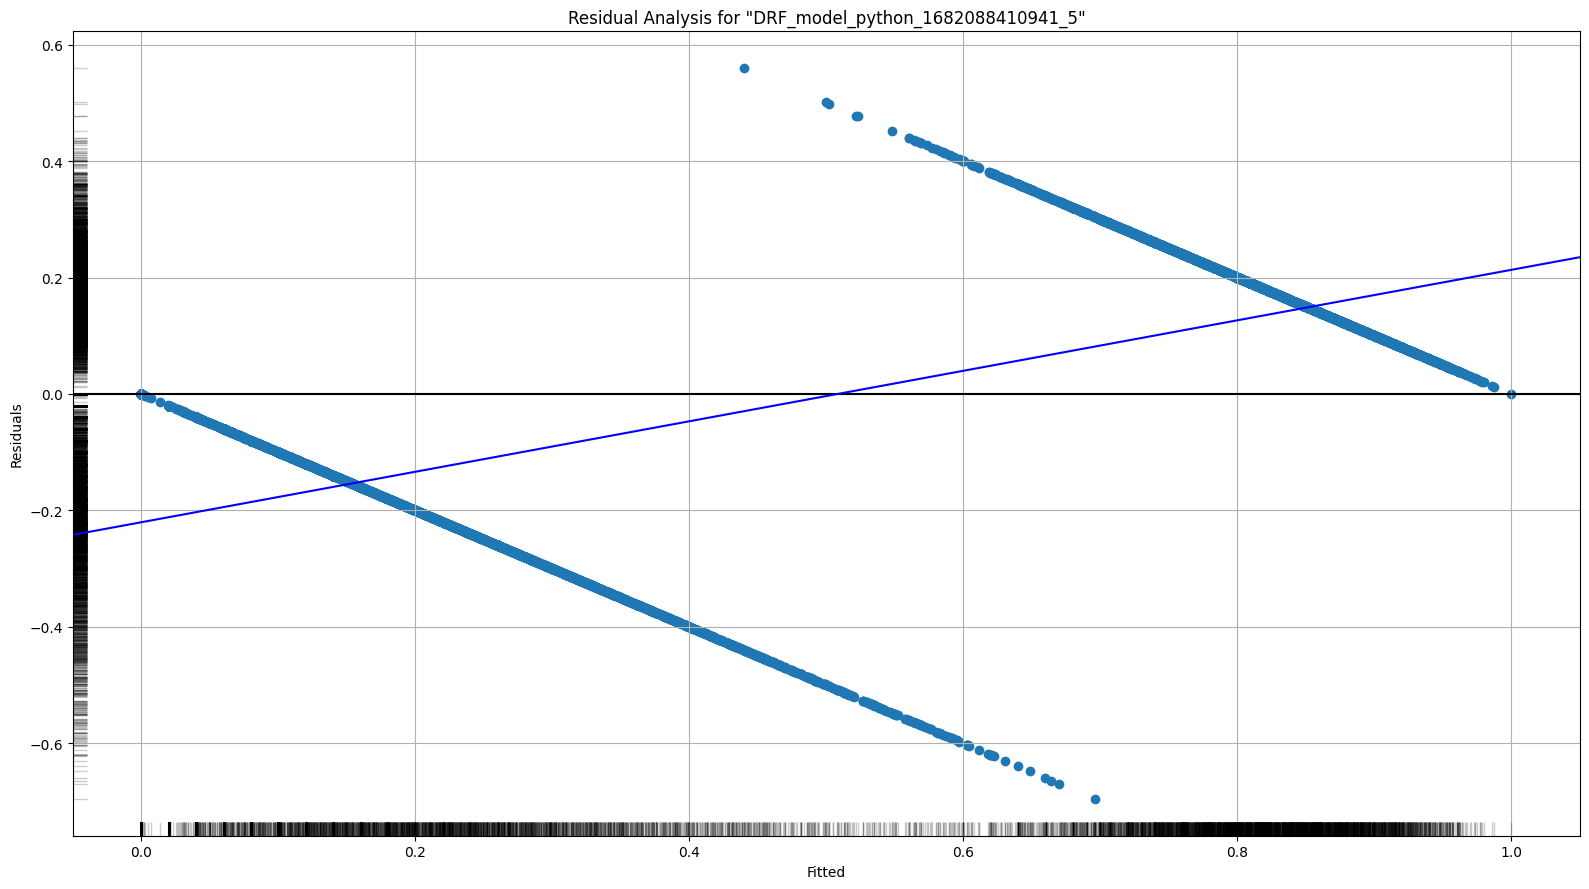

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

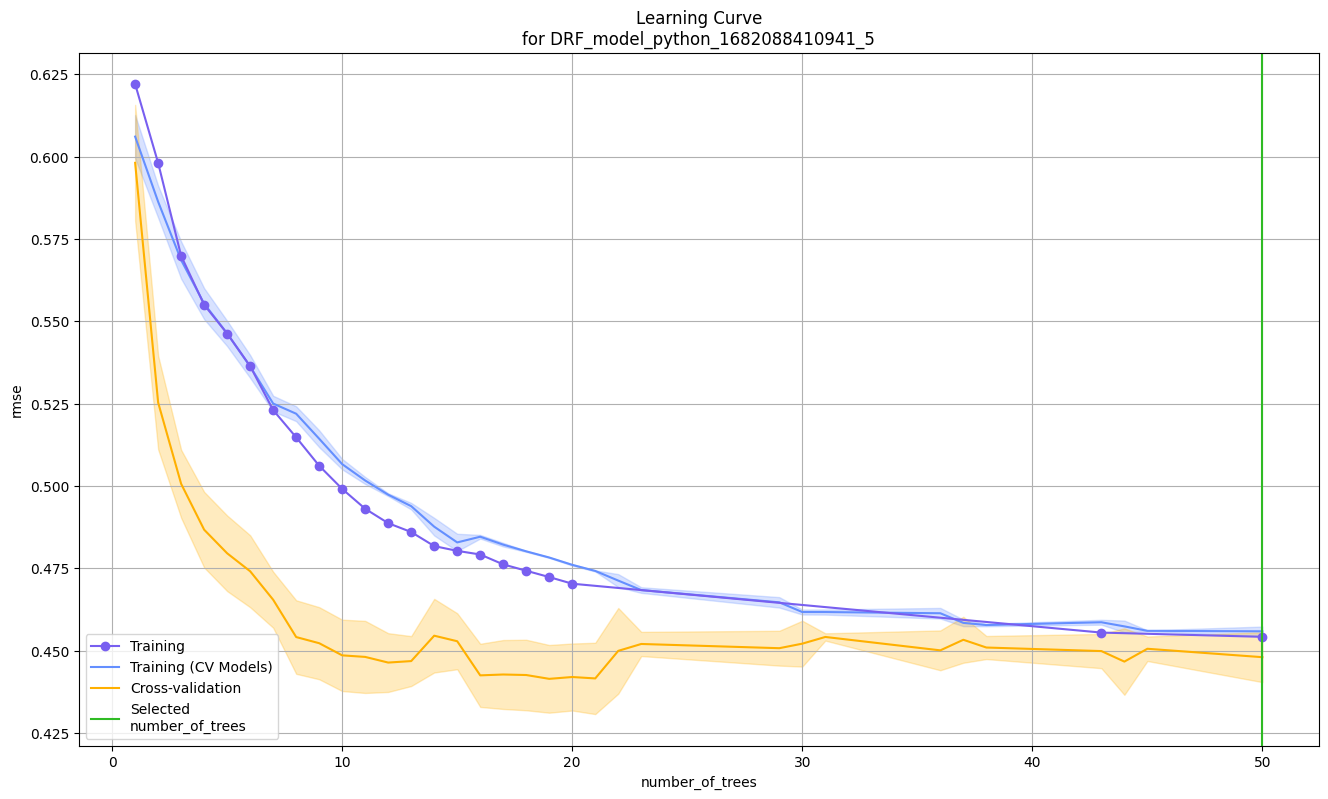

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

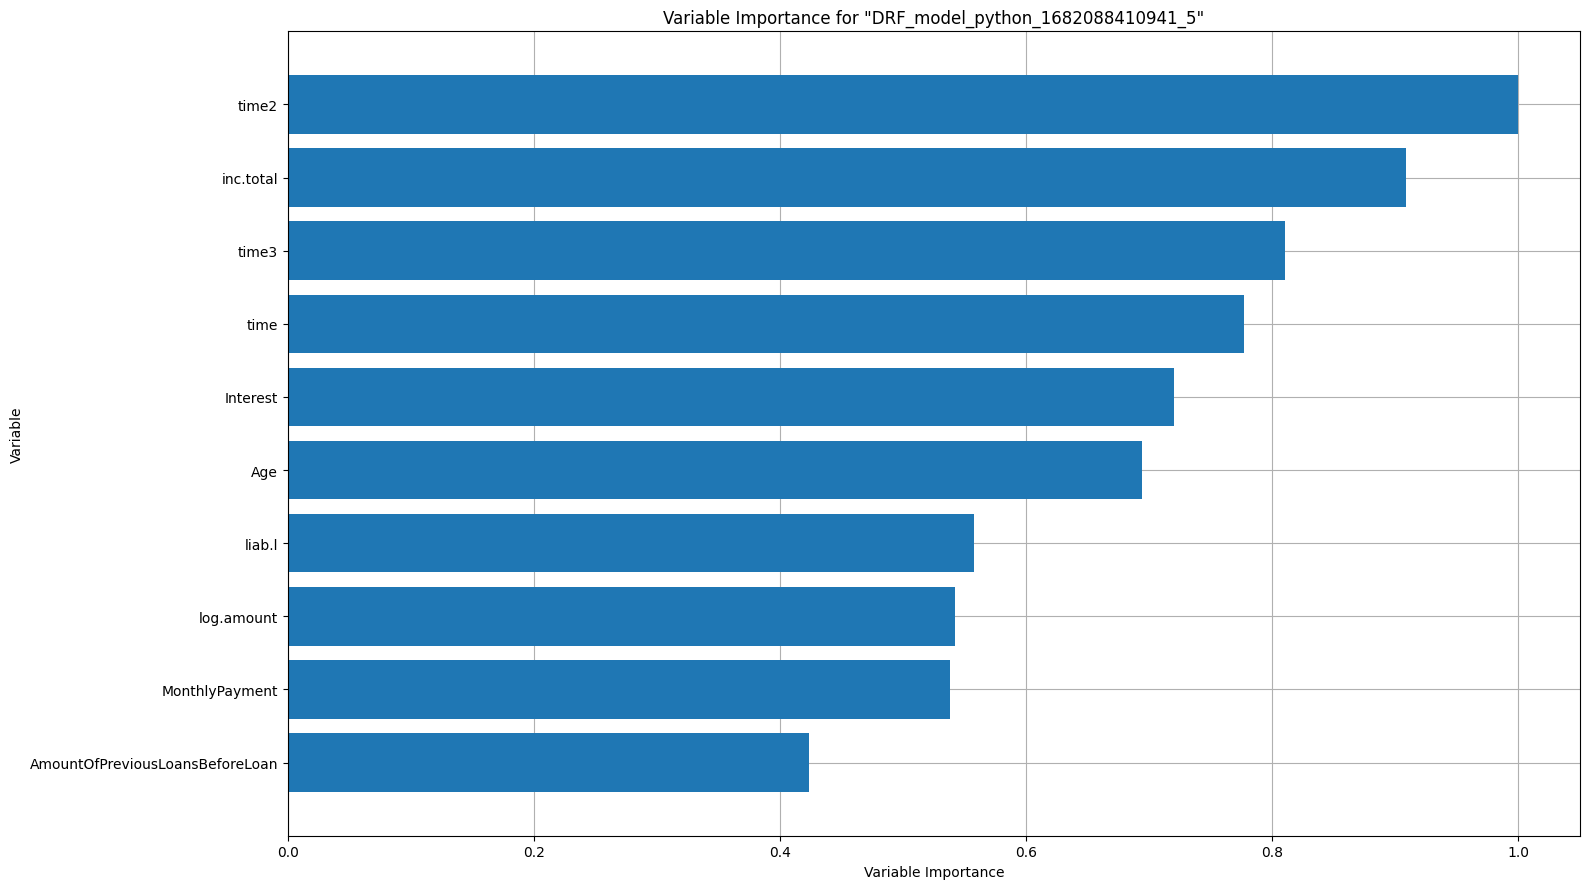

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_a0accb776e4d399c7d8c6a47ed74451b> was cancelled by the user.

In [78]:
model.explain(train_h2o)

## Evaluate the model

In [ ]:
test_h2o

In [79]:
performance = model.model_performance(test_data=test_h2o)
print(performance)

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.19725249367641573
RMSE: 0.44413116719772744
MAE: 0.39883309930246313
RMSLE: 0.3128593279042839
Mean Residual Deviance: 0.19725249367641573


## Make predictions

### H20 predictions

In [88]:
# TODO ALSO do predictions on the training set.
predictions_h2o = model.predict(test_h2o)
#predictions_h2o = model.predict(train_h2o)


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


### Convert h20 predictions to pandas

In [89]:
predictions = h2o_to_pandas(predictions_h2o)

In [90]:
predictions.head()

,predict
0,0.924102
1,0.020000
2,0.161765
3,0.640000
4,0.842009


## Evaluate predictions

### Binary classification Report

In [93]:
y_true = pd.DataFrame(y_test)  # Assuming y_test is a pandas DataFrame
y_pred = predictions['predict']

# Apply threshold of 0.5 to convert probabilities to binary 0 or 1
y_pred_binary = y_pred.apply(lambda x: 1 if x >= 0.5 else 0)

# Compute classification metrics using the binary_classification_metrics() function
metrics = binary_classification_metrics(y_true, y_pred_binary)

Accuracy: 0.98625
Confusion Matrix:
 [[3880  108]
 [   2 4010]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      3988
           1       0.97      1.00      0.99      4012

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



### ROC and PR Curve

In [94]:
metrics = evaluate_predictions(y_true, y_pred, roc_file='roc_plot_156_features.html', pr_file='pr_plot_156_features.html')
#metrics = evaluate_predictions(y_true, y_pred, roc_file='roc_plot_162_features.html', pr_file='pr_plot_162_features.html')

AUC: 0.9999
Average Precision: 0.9999


## Shut down the H2O cluster:

In [ ]:
h2o.cluster().shutdown()


# AUTO ML in R


In [ ]:
# ----------------------------------------------------------------------------- #
# ----------------------------------------------------------------------------- #
# ------------------------------ AUTO ML IN R --------------------------------- #
# ----------------------------------------------------------------------------- #
# ----------------------------------------------------------------------------- #


# R interface for 'H2O', the scalable open source machine learning platform that 
# offers parallelized implementations of many supervised and unsupervised machine 
# learning algorithms such as: 
# - Generalized Linear Models (GLM), 
# - Gradient Boosting Machines (including XGBoost), 
# - Random Forests, 
# - Deep Neural Networks (Deep Learning), 
# - Stacked Ensembles, 
# - Naive Bayes, 
# - Generalized Additive Models (GAM),
# - ....

# as well as a fully automatic machine learning algorithm (H2O AutoML).


# Within this script, we will learn how to initiate a cluster and run H20's AutoML
# which can be used for automating the machine learning workflow. 


# Setting up H20
# Java is a prerequisite for H2O, even if using it from the R or Python packages.
# You must have JAVA installed on your PC. 
# *For Mac: https://www.java.com/en/download/apple.jsp   
# *For Windows: https://www.java.com/download/ie_manual.jsp


# For further details, please check: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html


# Installing & initializing H20. In case you have past installations, you should run 
# lines 37-44. If this is the first time installing, you can only run lines 43-44.
if ("package:h2o" %in% search()) { detach("package:h2o", unload=TRUE) }
if ("h2o" %in% rownames(installed.packages())) { remove.packages("h2o") }
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages()))) { install.packages(pkg) }
}
install.packages("h2o", type="source", repos=(c(http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R)))
library(h2o)


# Call other necessary libraries 
library(data.table)
library(writexl)


# Initialize H2O cluster
h2o.init()


# Load dataset
setwd("~/Library/CloudStorage/OneDrive-SharedLibraries-BernerFachhochschule/bfh-bfhinternal - General/SBD3/Week 5")
df <- h2o.importFile("Employee-Attrition_cleaned.csv")  # In case this does not work, try the lines below:
df <- as.h2o(df)

df <- read_csv("Employee-Attrition_cleaned.csv")


# Identify the categorical variables in the dataset
cat_cols <- c()
for (col in names(df)) {
  if (class(df[[col]]) == "factor" | typeof(df[[col]]) == "character") {
    cat_cols <- c(cat_cols, col)
  }
}

# Convert the categorical variables to factors
df[cat_cols] <- lapply(df[cat_cols], factor)
str(df)

df <- as.h2o(df)



# Split dataset into training and validation sets
set.seed(12)
splits <- h2o.splitFrame(df, ratios = c(0.8))
train <- splits[[1]]
valid <- splits[[2]]

dep_var <- "Attrition"

# Run AutoML

# The current version of AutoML trains and cross-validates the following algorithms: 
# * three pre-specified XGBoost GBM (Gradient Boosting Machine) models,
# * a fixed grid of GLMs, 
# * a default Random Forest (DRF), 
# * five pre-specified H2O GBMs, 
# * a near-default Deep Neural Net, 
# * an Extremely Randomized Forest (XRT), 
# * a random grid of XGBoost GBMs, 
# * a random grid of H2O GBMs, and 
# * a random grid of Deep Neural Nets. 

# In some cases, there will not be enough time to complete all the algorithms, 
# so some may be missing from the leaderboard. In other cases, the grids will 
# stop early, and if there’s time left, the top two random grids will be 
# restarted to train more models. AutoML trains multiple Stacked Ensemble models 
# throughout the process (more info about the ensembles below).

automl <- h2o.automl(
  x = setdiff(colnames(df), dep_var), # independent variables
  y = dep_var, # dependent variable
  training_frame = train,
  max_runtime_secs = 600, # maximum time in seconds for AutoML to run
  seed = 12 # set seed for reproducibility
)


# View leaderboard of models generated by AutoML
lb <- automl@leaderboard
print(lb, n = nrow(lb)) 


# We can also export the table and observe the result more in-depth.
lb_table <- as.data.table(lb)
write_xlsx(lb_table, "trained_ML_models.xlsx")        # The excel file will be located in your set working directory. 


# Find the best performing model per a certain criteria and explore it.
best_auc <- h2o.get_best_model(automl, criterion = "auc")   # Best model per the AUC indicator. 
best_auc                                                    # Let's explore the best perfroming model 


# Find the best performing models across different criteria (logloss, area under the precision-recall curve (aucpr), etc.)
best_logloss <- h2o.get_best_model(automl, criterion = "logloss")
best_aucpr <- h2o.get_best_model(automl, criterion = "aucpr")
best_mean_per_class_error <- h2o.get_best_model(automl, criterion = "mean_per_class_error")


# Get training timing info
trainingInfo <- automl@training_info
trainingInfo


# Predictions and performance on our validation sample. 
# Obtain the predictions for our validation subset
pred_best_auc <- h2o.predict(best_auc, valid)
predictions <- as.data.table(pred_best_auc)
perf_best_auc <- h2o.performance(best_auc, valid)

# Summarize the performance. 
# We build a function that can extract the individual performance indicators like
# auc, loglog and aucpr for the best performing model.
performance_single <- function(perf_object){
  capture.output(cat("logloss", h2o.logloss(perf_object), 
                     "auc", h2o.auc(perf_object), 
                     "aucpr", h2o.aucpr(perf_object)))
}

# Check the results for the best performing model (by auc value)
single_best_auc <- performance_single(perf_best_auc)
single_best_auc


# Obtain the confusion matrix
conf_matrix_best_auc <- h2o.confusionMatrix(perf_best_auc)
conf_matrix_best_auc


# Plot the ROC and the Precision Recall curve
plot(perf_best_auc, type = "roc")
plot(perf_best_auc, type = "pr")


# ----------------------------------------------------------------------------- #
# ----------------------------------------------------------------------------- #
# ----------------------- Explainability in H20 ----------- ------------------- #
# ----------------------------------------------------------------------------- #
# ----------------------------------------------------------------------------- #

# H20 framework explained (for further details check the documentation:
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html)
# H2O Explainability Interface is a convenient wrapper to a number of explainabilty 
# methods and visualizations in H2O. The main functions:
#  * h2o.explain() (global explanation)
#  * h2o.explain_row() (local explanation) 
# work for individual H2O models, as well a list of models or an H2O AutoML object. 

# The h2o.explain() function generates a list of explanations – individual units 
# of explanation such as a Partial Dependence plot or a Variable Importance plot. 
# Most of the explanations are visual – these plots can also be created by individual 
# utility functions outside the h2o.explain() function. The visualization engine 
# used in the R interface is the ggplot2 package


# When h2o.explain() is provided a list of models, the following global explanations 
# will be generated by default:
#  * Leaderboard (compare all models)
#  * Confusion Matrix for Leader Model (classification only)
#  * Residual Analysis for Leader Model (regression only)
#  * Variable Importance of Top Base (non-Stacked) Model
#  * Variable Importance Heatmap (compare all non-Stacked models)
#  * Model Correlation Heatmap (compare all models)
#  * SHAP Summary of Top Tree-based Model (TreeSHAP)
# * Partial Dependence (PD) Multi Plots (compare all models)
# * Individual Conditional Expectation (ICE) Plots


# Global explainations -- we explain the innerworkings of the model as a whole.

# Explain leader model & compare with all AutoML models
exp_automl <- h2o.explain(automl, valid) 
print(exp_automl) 


# Explain a specific model 
GBM_auc <- h2o.get_best_model(automl, algorithm = "GBM", criterion = "auc")
GLM_auc <- h2o.get_best_model(automl, algorithm = "GLM", criterion = "auc")
DRF_auc <- h2o.get_best_model(automl, algorithm = "DRF", criterion = "auc")
DL_auc <- h2o.get_best_model(automl, algorithm = "DeepLearning", criterion = "auc")
XGB_auc <- h2o.get_best_model(automl, algorithm = "XGBoost", criterion = "auc")

exp_GBM <- h2o.explain(GBM_auc, valid)  # Explain the best perfroming GBM model 
print(exp_GBM)


# Local explanations -- Explain a specific unit (i.e. obtain explainations for 
# a single person in the sample). 

# In the following step, we explain the behavior of a model or group of models 
# with respect to a single row of data. By using the h2o.explain_row() function, 
# the outputs would be: 
#  * SHAP Contribution Plot (for the top tree-based model in AutoML)
#  * Individual Conditional Expectation (ICE) Plots

# In the next line, we explain how the model performs for a single row (row 4 from
# the validation set)
row_4_GBM_auc <- h2o.explain_row(GBM_auc, valid, row_index = 4)
row_4_GBM_auc
